# Data Augmentation Analysis

In this notebook, we will explore and implement data augmentation techniques to enhance the diversity and balance of the dataset for speech emotion recognition. The goal is to improve model robustness and generalization by introducing realistic variations to the audio data.

### Strategy Overview

1. **Augmentation Techniques**:
   - Time Stretching
   - Pitch Shifting
   - Noise Injection
   - Dynamic Range Compression
   - Reverberation
   - Cropping and Padding

2. **Implementation Plan**:
   - Apply augmentation techniques to underrepresented classes.
   - Generate multiple augmented samples per original file to increase diversity.

3. **Visualization and Analysis**:
   - Visualize the spectrograms of augmented samples to ensure emotional content is preserved.
   - Compare the distributions of augmented and original datasets (e.g., pitch, duration, intensity).

4. **Evaluation**:
   - Train a baseline model on the original dataset.
   - Train the same model on the augmented dataset.
   - Compare performance metrics (e.g., accuracy, F1-score) to evaluate the impact of augmentation.

5. **Iterative Refinement**:
   - Adjust augmentation parameters based on evaluation results.
   - Avoid over-augmentation, which can lead to unrealistic data.

---

Let's start by loading the dataset and preprocess it based on decisions from 01_data_exploration notebook.

In [1]:
# Preprocess the dataset based on decisions from the previous notebook
import sys
import os
import pandas as pd

import warnings
warnings.filterwarnings ('ignore')
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings(action="ignore"):
    fxn()

# Add the src directory to the Python path
sys.path.append(os.path.abspath("../src"))
from data_loader import EmotionDataset, DatasetConfig

# Load dataset metadata
DATA_ROOT = "D:\\Projects\\Technion\\EmotionDetection\\data"
ds_cfg = DatasetConfig(data_root=DATA_ROOT)
ds_work = EmotionDataset(ds_cfg)

# Preprocess the dataset
ds_work.preprocess()

# Print the updated class distribution
print("Updated Class Distribution:")
print(pd.Series(ds_work.emotions).value_counts())

Updated Class Distribution:
3    2103
1    1923
2    1923
5    1863
4    1863
0    1703
6     592
Name: count, dtype: int64


In [2]:
# Analyze the impact of augmentation manipulations
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve

# Define augmentation functions
def time_stretch(y, rate):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, n_steps):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def add_noise(y, noise_level=0.005):
    noise = np.random.normal(0, noise_level, y.shape)
    return y + noise

def dynamic_range_compression(y, factor=0.5):
    return np.sign(y) * (np.abs(y) ** factor)

def add_reverberation(y, sr, reverb_factor=0.3):
    impulse_response = np.zeros(int(sr * reverb_factor))
    impulse_response[::int(sr * reverb_factor / 10)] = 1
    impulse_response /= np.sum(impulse_response)  # Normalize the impulse response
    return convolve(y, impulse_response, mode='full')[:len(y)]

def crop_audio(y, sr, crop_duration):
    crop_samples = int(crop_duration * sr)
    return y[:crop_samples] if crop_samples < len(y) else y

def pad_audio(y, sr, target_duration):
    target_samples = int(target_duration * sr)
    if len(y) < target_samples:
        padding = target_samples - len(y)
        return np.pad(y, (0, padding), mode='constant')
    return y

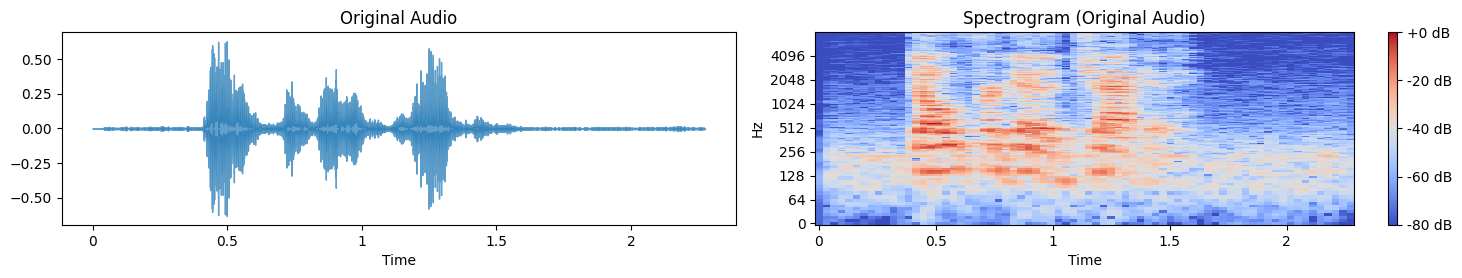

Original Duration: 2.28 seconds


In [3]:
# Select a sample audio file
sample_file = ds_work.paths[0]

y, sr = librosa.load(sample_file, sr=None)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

plt.tight_layout()
plt.show()
print("Original Duration: {:.2f} seconds".format(len(y) / sr))
Audio(data=y, rate=sr)

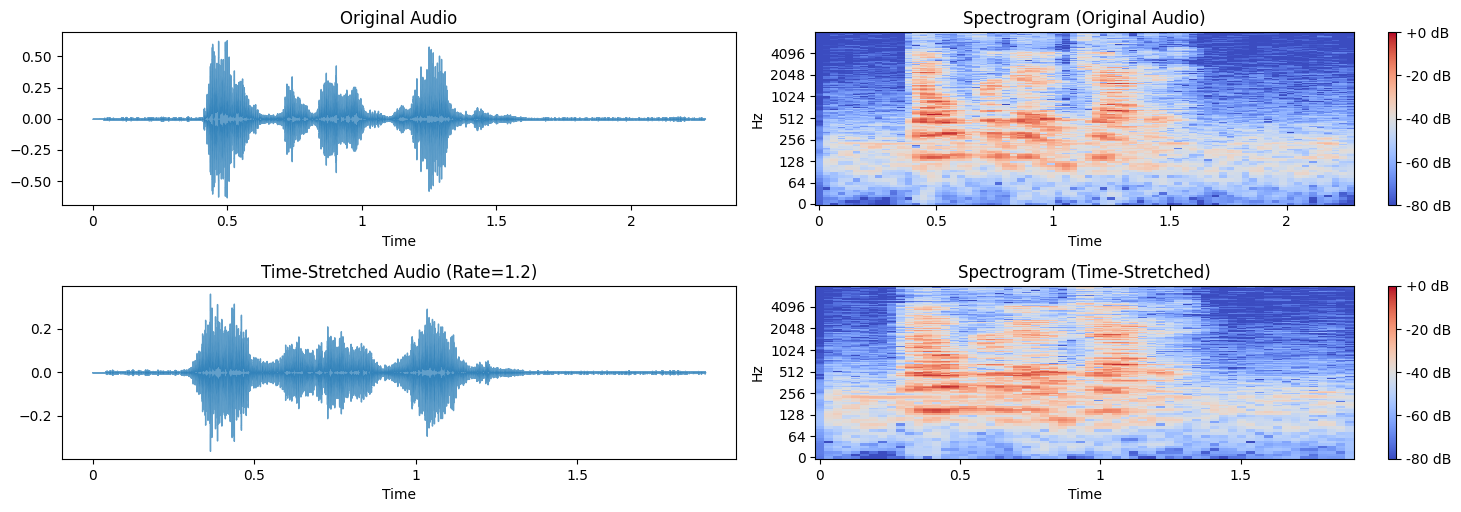

Stretched Duration: 1.90 seconds


In [4]:
stretched = time_stretch(y, rate=1.2)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

# Plot waveform
plt.subplot(8, 2, 3)
librosa.display.waveshow(stretched, sr=sr, alpha=0.7)
plt.title("Time-Stretched Audio (Rate=1.2)")

# Plot spectrogram
plt.subplot(8, 2, 4)
D_stretched = librosa.amplitude_to_db(np.abs(librosa.stft(stretched)), ref=np.max)
librosa.display.specshow(D_stretched, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Time-Stretched)")

plt.tight_layout()
plt.show()
print("Stretched Duration: {:.2f} seconds".format(len(stretched) / sr))
Audio(data=stretched, rate=sr)

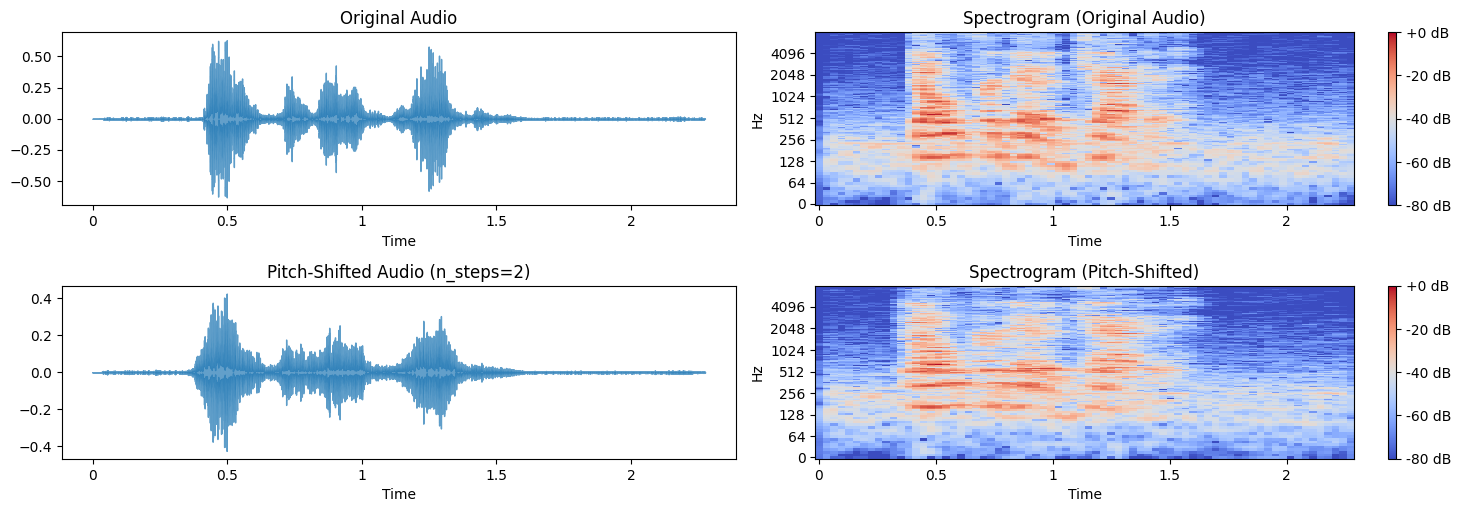

In [5]:
pitched = pitch_shift(y, sr, n_steps=2)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

# Plot waveform
plt.subplot(8, 2, 3)
librosa.display.waveshow(pitched, sr=sr, alpha=0.7)
plt.title("Pitch-Shifted Audio (n_steps=2)")

# Plot spectrogram
plt.subplot(8, 2, 4)
D_pitched = librosa.amplitude_to_db(np.abs(librosa.stft(pitched)), ref=np.max)
librosa.display.specshow(D_pitched, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Pitch-Shifted)")

plt.tight_layout()
plt.show()
Audio(data=pitched, rate=sr)

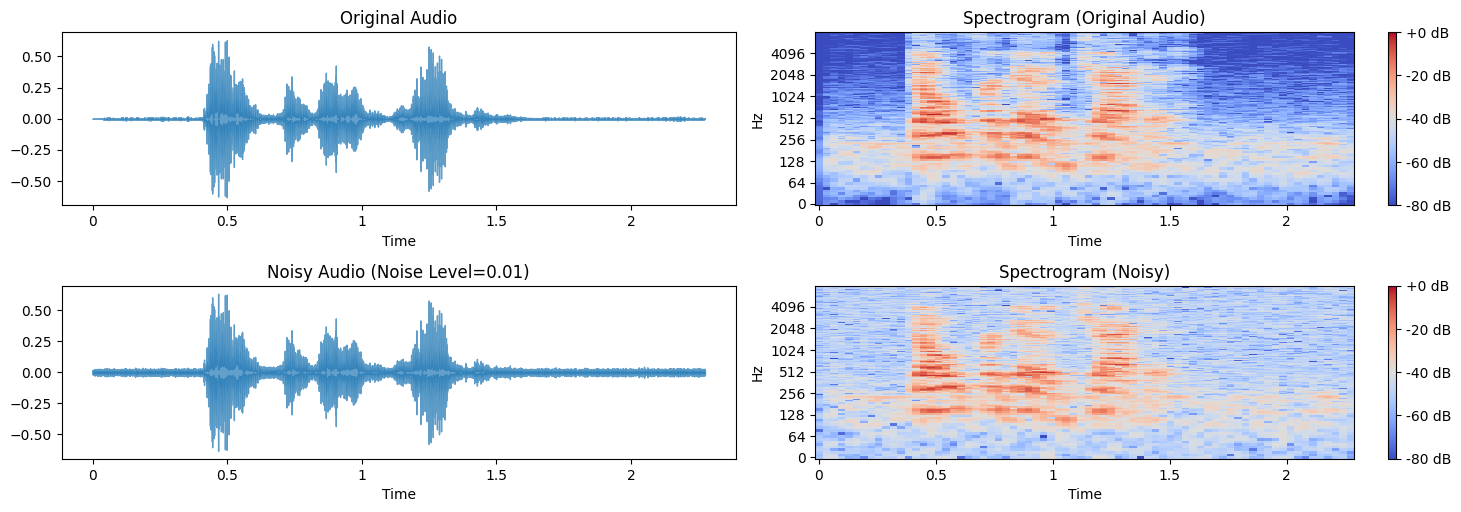

In [6]:
noisy = add_noise(y, noise_level=0.01)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

# Plot waveform
plt.subplot(8, 2, 3)
librosa.display.waveshow(noisy, sr=sr, alpha=0.7)
plt.title("Noisy Audio (Noise Level=0.01)")

# Plot spectrogram
plt.subplot(8, 2, 4)
D_noisy = librosa.amplitude_to_db(np.abs(librosa.stft(noisy)), ref=np.max)
librosa.display.specshow(D_noisy, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Noisy)")

plt.tight_layout()
plt.show()
Audio(data=noisy, rate=sr)

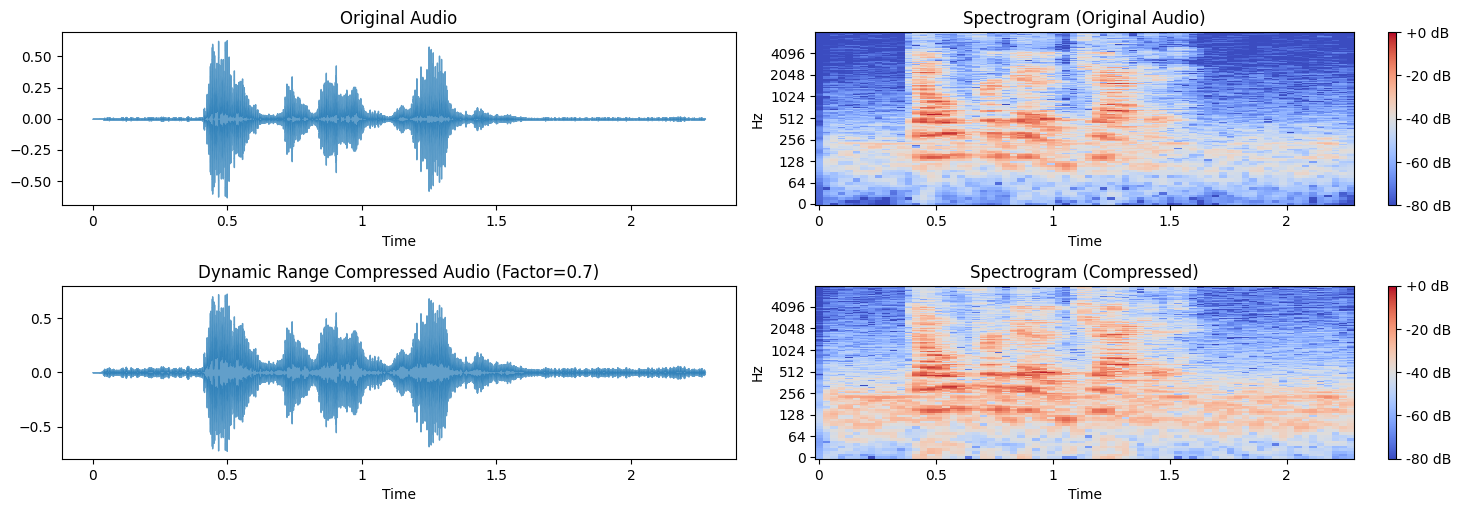

Compressed: No change in duration


In [7]:
compressed = dynamic_range_compression(y, factor=0.7)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

# Plot waveform
plt.subplot(8, 2, 3)
librosa.display.waveshow(compressed, sr=sr, alpha=0.7)
plt.title("Dynamic Range Compressed Audio (Factor=0.7)")

# Plot spectrogram
plt.subplot(8, 2, 4)
D_compressed = librosa.amplitude_to_db(np.abs(librosa.stft(compressed)), ref=np.max)
librosa.display.specshow(D_compressed, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Compressed)")

plt.tight_layout()
plt.show()
print("Compressed: No change in duration")
Audio(data=compressed, rate=sr)

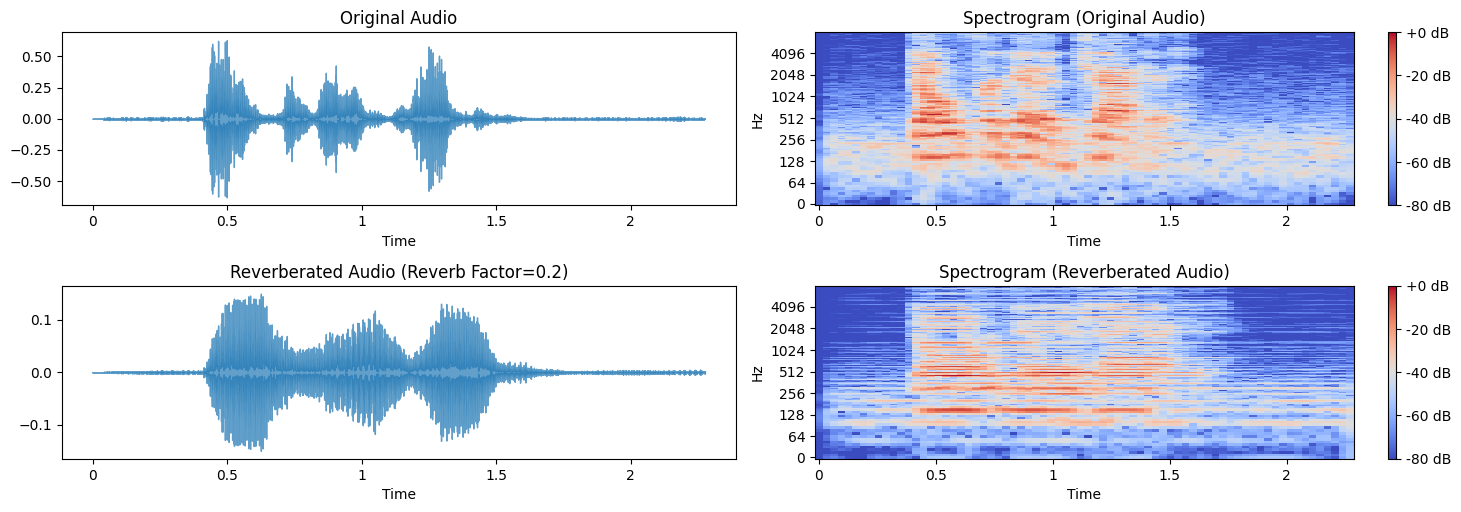

Reverberated: No change in duration


In [8]:
reverberated = add_reverberation(y, sr, reverb_factor=0.2)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

# Plot waveform
plt.subplot(8, 2, 3)
librosa.display.waveshow(reverberated, sr=sr, alpha=0.7)
plt.title("Reverberated Audio (Reverb Factor=0.2)")

# Plot spectrogram
plt.subplot(8, 2, 4)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(reverberated)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Reverberated Audio)")

plt.tight_layout()
plt.show()
print("Reverberated: No change in duration")
Audio(data=reverberated, rate=sr)

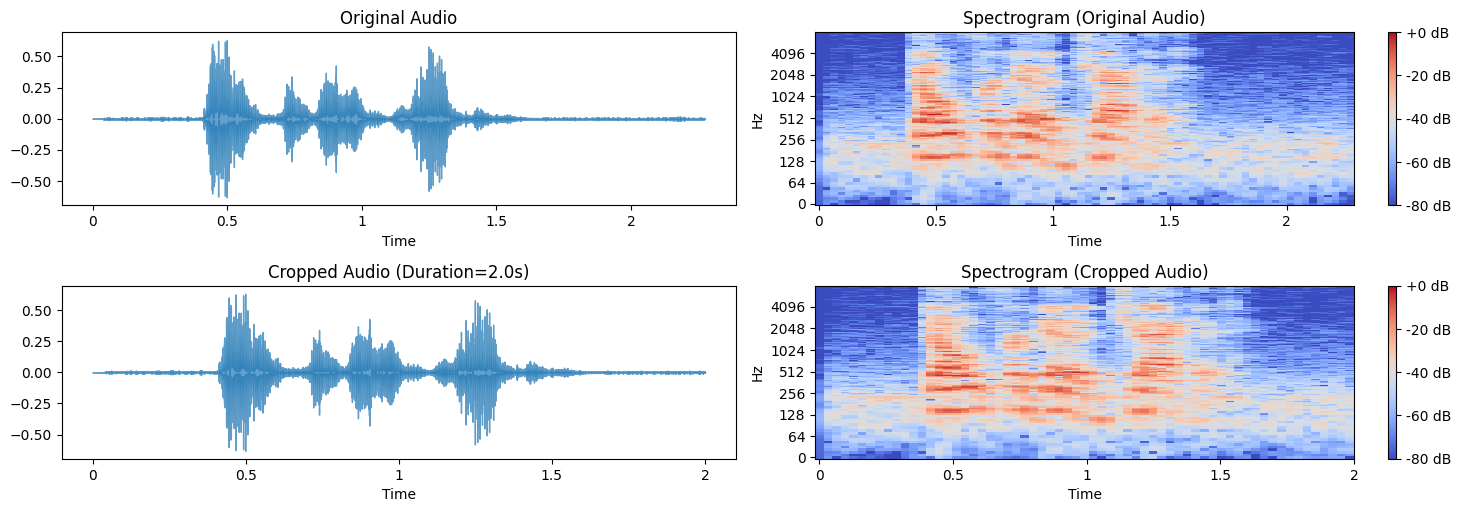

Cropped Duration: 2.00 seconds


In [9]:
cropped = crop_audio(y, sr, crop_duration=2.0)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

# Plot waveform
plt.subplot(8, 2, 3)
librosa.display.waveshow(cropped, sr=sr, alpha=0.7)
plt.title("Cropped Audio (Duration=2.0s)")

# Plot spectrogram
plt.subplot(8, 2, 4)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(cropped)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Cropped Audio)")

plt.tight_layout()
plt.show()
print("Cropped Duration: {:.2f} seconds".format(len(cropped) / sr))
Audio(data=cropped, rate=sr)

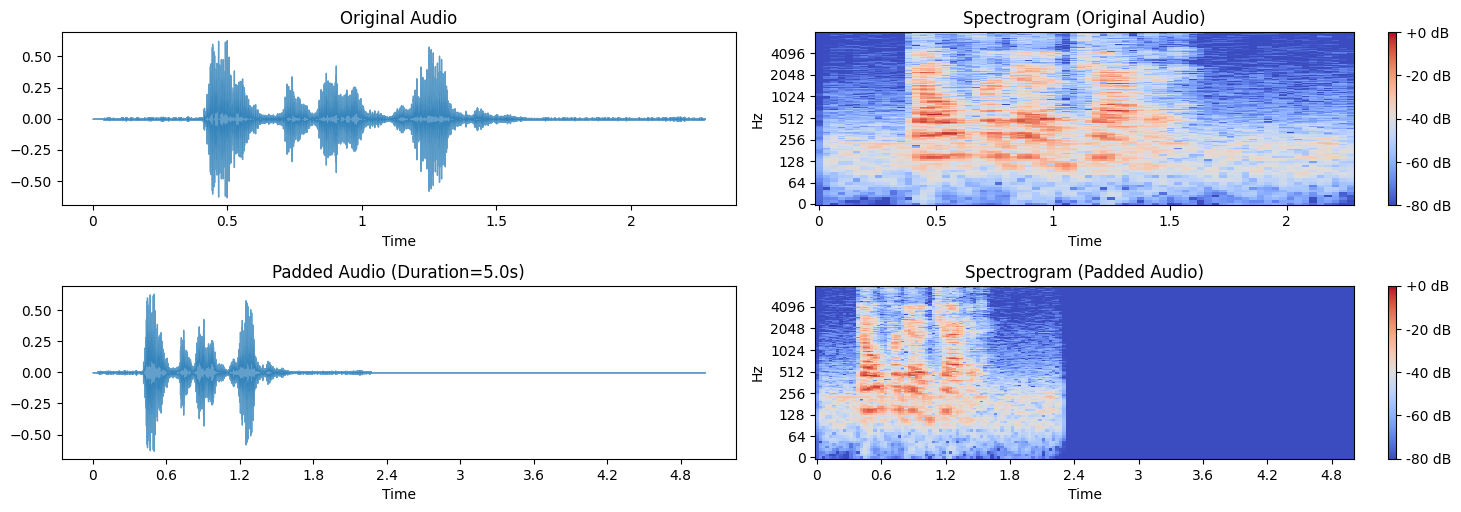

Padded Duration: 5.00 seconds


In [10]:
padded = pad_audio(y, sr, target_duration=5.0)
plt.figure(figsize=(15, 20))

# Plot waveform
plt.subplot(8, 2, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.title("Original Audio")

# Plot spectrogram
plt.subplot(8, 2, 2)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Original Audio)")

# Plot waveform
plt.subplot(8, 2, 3)
librosa.display.waveshow(padded, sr=sr, alpha=0.7)
plt.title("Padded Audio (Duration=5.0s)")

# Plot spectrogram
plt.subplot(8, 2, 4)
Y = librosa.amplitude_to_db(np.abs(librosa.stft(padded)), ref=np.max)
librosa.display.specshow(Y, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Padded Audio)")

plt.tight_layout()
plt.show()
print("Padded Duration: {:.2f} seconds".format(len(padded) / sr))
Audio(data=padded, rate=sr)

## Impact on Model Performance

In this section, we will evaluate the impact of data augmentation on model performance. The steps include:

1. **Feature Extraction**:
   - Extract Mel-frequency cepstral coefficients (MFCC) from the audio data.

2. **Model Definition**:
   - Define a simple neural network model for classification.

3. **Training and Evaluation**:
   - Train the model on a subset of the original data.
   - Train the model on the augmented data.
   - Compare the performance metrics (e.g., accuracy, loss) to assess the impact of augmentation.

In [ ]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Define a function to extract MFCC features
def extract_mfcc(file_path, sr=22050, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Define a custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]
        features = extract_mfcc(file_path)
        if self.transform:
            features = self.transform(features)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Load dataset paths and labels
file_paths = ds_work.paths
labels = ds_work.emotions

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Reduce the dataset to 20% of its original size
reduced_size = int(0.1 * len(file_paths))
file_paths = file_paths[:reduced_size]
labels = labels[:reduced_size]
encoded_labels = encoded_labels[:reduced_size]

# Split the dataset into training and testing subsets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, encoded_labels, test_size=0.2, random_state=42
)

# Create DataLoader instances
train_dataset = EmotionDataset(train_paths, train_labels)
test_dataset = EmotionDataset(test_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = 13  # Number of MFCC features
num_classes = len(label_encoder.classes_)
model = SimpleNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    batch_idx = 0
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_idx += 1
            print(f"\rBatch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}", end="", flush=True)
        batch_idx = 0
        print(f"\rEpoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}\n", end="", flush=True)

# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

# Train and evaluate on the part of original dataset
print("Training on part of Original Dataset")
train_model(model, train_loader, criterion, optimizer, epochs=5)
evaluate_model(model, test_loader)

Training on part of Original Dataset
Epoch 1/5, Loss: 9.4514751
Epoch 1/5, Loss: 9.4514


KeyboardInterrupt: 